In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
from pathlib import Path

sns.set()
sns.set_style('ticks',{'axes.grid' : False})
%matplotlib inline

In [2]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = Path('./refactor/data/proc/PS_v5_beta_0-4_pc_scaled_ipfx_eqTE.mat')
E_names_file = Path('./refactor/data/proc/E_names.json')
figure_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/'

O = sio.loadmat(origdata_pth,squeeze_me=True)

In [3]:
np.unique(O['cluster']).shape

(59,)

In [4]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = Path('./refactor/data/proc/PS_v5_beta_0-4_pc_scaled_ipfx_eqTE.mat')
E_names_file = Path('./refactor/data/proc/E_names.json')
figure_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'

O = sio.loadmat(origdata_pth,squeeze_me=True)
O['E_dat']=np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
O['E_names']=np.concatenate([O['pc_name'],O['feature_name']],axis = 0)
with open(E_names_file) as f:
    temp = json.load(f)
O['E_names'] = np.array([temp[i] for i in O['E_names']])


#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
aug = 1
fiton='zT'
n_cvfolds = 43
        
CVdict={}
key_list = ['XrT','XrT_from_XE','XrE','XrE_from_XT','train_ind','val_ind','test_ind']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_cs_'+str(lambda_TE)+\
                '_ad_'+str(aug)+\
                '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                '_ri_0-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    if Path(representation_pth+cvfold_fname).is_file(): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X
    else:
        print(cvfold_fname,'not found')

100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


#### Plot differentially expressed genes for internal nodes:
- 109 : Pvalb
-  90 : Sst
-  63 : Vip
-  76 : Lamp5+Sncg

In [5]:
from refactor.utils.tree_helpers import HTree
htree = HTree(htree_file = './refactor/data/proc/dend_RData_Tree_20181220.csv')
G = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/DE_gene_dict.mat')

avail_nodes = list(G.keys())
for class_lbl in ['n109','n90','n63','n76']:
    subtree_nodes = htree.get_descendants(node=class_lbl,leafonly=False)
    subtree_nodes = list(set(subtree_nodes) & set(avail_nodes))
    DEgenes = []
    for node in subtree_nodes:
        DEgenes.extend(G[node])
    DEgenes = [gene.rstrip().lstrip() for gene in DEgenes]
    DEgenes = list(set(DEgenes) & set(O['gene_id'].tolist()))
    print(f'{len(DEgenes)} diff. exp. genes found for descendants of {class_lbl}')

96 diff. exp. genes found for descendants of n109
113 diff. exp. genes found for descendants of n90
110 diff. exp. genes found for descendants of n63
106 diff. exp. genes found for descendants of n76


In [6]:
gene_subsets = {}

#Marker genes in the Tasic 2018 paper: 
gene_subsets['markers_sst_pvalb'] = ['Sst', 'Chodl', 'Nos1', 'Mme', 'Tac1', 
                                     'Tacr3', 'Calb2', 'Nr2f2', 'Myh8', 'Tac2', 
                                     'Hpse', 'Crhr2', 'Crh', 'Esm1', 'Rxfp1', 
                                     'Nts', 'Pvalb', 'Gabrg1', 'Th', 'Calb1', 
                                     'Akr1c18', 'Sema3e', 'Gpr149', 'Reln', 
                                     'Tpbg', 'Cpne5', 'Vipr2', 'Nkx2-1']

gene_subsets['markers_lamp5_serpinf1_sncg_vip'] = ['Lamp5', 'Ndnf', 'Krt73', 'Fam19a1', 
                                                   'Pax6', 'Ntn1', 'Plch2', 'Lsp1', 'Lhx6', 
                                                   'Nkx2.1', 'Vip', 'Sncg', 'Slc17a8', 'Nptx2', 
                                                   'Gpr50', 'Itih5', 'Serpinf1', 'Igfbp6', 
                                                   'Gpc3', 'Lmo1', 'Ptprt', 'Rspo4', 'Chat', 
                                                   'Crispld2', 'Col15a1', 'Pde1a']

#Neuropeptide genes in the Smith 2019 paper: 
gene_subsets['npp']  = ['Vip','Npy','Sst','Penk','Tac2','Cck','Crh',
                             'Tac1','Pdyn','Cort','Pthlh','Pnoc','Adcyap1',
                             'Trh','Grp','Nmb','Nts','Rln1','Vipr1','Vipr2',
                             'Npy1r','Npy2r','Npy5r','Sstr1','Sstr2',
                             'Sstr3','Sstr4','Oprd1','Oprm1','Tacr3',
                             'Cckbr','Crhr1','Crhr2','Tacr1','Oprk1',
                             'Pth1r','Oprl1','Adcyap1r1','Trhr','Trhr2',
                             'Grpr','Nmbr','Ntsr1','Ntsr2','Rxfp1','Rxfp2',
                             'Rxfp3']

gene_subsets['combined_markers'] = gene_subsets['markers_lamp5_serpinf1_sncg_vip']+gene_subsets['markers_sst_pvalb']

In [7]:
set(gene_subsets['combined_markers']) & set(gene_subsets['npp'])

{'Crh',
 'Crhr2',
 'Nts',
 'Rxfp1',
 'Sst',
 'Tac1',
 'Tac2',
 'Tacr3',
 'Vip',
 'Vipr2'}

In [18]:
subset = 'npp'

gene_list = gene_subsets[subset]

#Find location of all genes
gene_inds = []
for gene in gene_list:
    ind = np.flatnonzero(np.isin(O['gene_id'],gene))
    if ind.size==1:
        gene_inds.append(ind[0])
gene_inds = np.array(gene_inds)
genes_found = O['gene_id'][gene_inds].tolist()

In [19]:
not_found=list(set(gene_list)-set(genes_found))
print(f'{len(not_found)} out of {len(gene_list)} genes not found among genes used as autoencoder input')

11 out of 47 genes not found among genes used as autoencoder input


In [20]:
csTE = '1-0'
aE = '1-0'

cv_list = CVdict.keys()
XrT = np.concatenate([CVdict[cv]['XrT'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrT_from_XE = np.concatenate([CVdict[cv]['XrT_from_XE'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrE = np.concatenate([CVdict[cv]['XrE'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrE_from_XT = np.concatenate([CVdict[cv]['XrE_from_XT'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)

val_ind = np.concatenate([CVdict[cv]['val_ind'] for cv in cv_list],axis=0)

### T reconstruction $R^2$

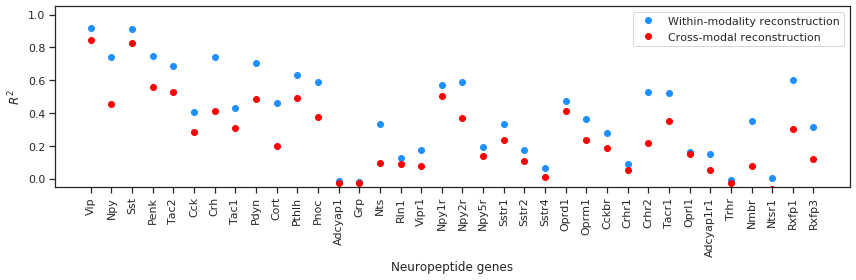

In [21]:
R2_T_to_T = 1 - np.mean((O['T_dat'][val_ind,:] - XrT)**2,axis=0)/np.var(O['T_dat'][val_ind,:],axis=0)
R2_E_to_T = 1 - np.mean((O['T_dat'][val_ind,:] - XrT_from_XE)**2,axis=0)/np.var(O['T_dat'][val_ind,:],axis=0)

fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(len(genes_found)), R2_T_to_T[gene_inds],'o',color='dodgerblue',label='Within-modality reconstruction')
plt.plot(np.arange(len(genes_found)), R2_E_to_T[gene_inds],'o',color='red',label='Cross-modal reconstruction')
plt.legend(frameon=True)
ax = plt.gca()
ax.set_ylabel(r'$R^2$')
ax.set_xlabel('Neuropeptide genes')
ax.set_ylim(-0.05,1.05)
ax.set_xticks(np.arange(len(genes_found)))
ax.set_xticklabels(genes_found,rotation=90)
plt.tight_layout()
#plt.savefig(figure_path+f'R2_{subset}_genes.png',dpi=300)
plt.savefig(figure_path+f'Fig_ED_6.jpg',dpi=300)
df = pd.DataFrame({'genes':genes_found,'within':R2_T_to_T[gene_inds],'cross':R2_E_to_T[gene_inds]})
df.to_csv(figure_path+f'Source_data_Fig_ED_6.csv',index=False)

### E reconstruction $R^2$

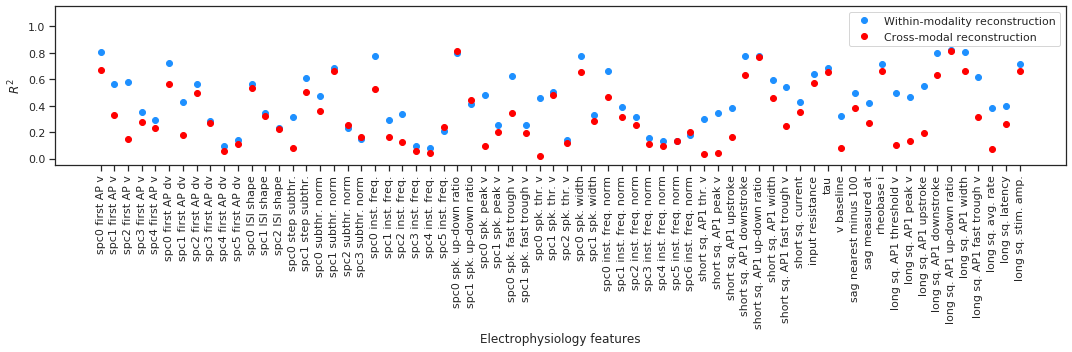

In [15]:
R2_E_to_E = 1 - np.nanmean((O['E_dat'][val_ind,:] - XrE)**2,axis=0)/np.nanvar(O['E_dat'][val_ind,:],axis=0)
R2_T_to_E = 1 - np.nanmean((O['E_dat'][val_ind,:] - XrE_from_XT)**2,axis=0)/np.nanvar(O['E_dat'][val_ind,:],axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(O['E_names'].size), R2_E_to_E[:],'o',color='dodgerblue',label='Within-modality reconstruction')
plt.plot(np.arange(O['E_names'].size), R2_T_to_E[:],'o',color='red',label='Cross-modal reconstruction')
plt.legend(frameon=True)
ax = plt.gca()
ax.set_ylabel(r'$R^2$')
ax.set_ylim(-0.05,1.15)
ax.set_xlabel("Electrophysiology features")
ax.set_xticks(np.arange(O['E_names'].size))
ax.set_xticklabels(O['E_names'],rotation=90)
plt.tight_layout()
#plt.savefig(figure_path+'R2_E_features.png',dpi=300)
plt.savefig(figure_path+f'Fig_ED_7.jpg',dpi=300)
plt.show()
df = pd.DataFrame({'features':O['E_names'],'within':R2_E_to_E[:],'cross':R2_T_to_E[:]})
df.to_csv(figure_path+f'Source_data_Fig_ED_7.csv',index=False)

In [27]:
figure_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/'

In [28]:
#Get ordered list of well-sampled t-types
from refactor.utils.tree_helpers import get_merged_ordered_classes
n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                   htree_file='./refactor/data/proc/dend_RData_Tree_20181220.csv',
                                                   n_required_classes=n_required_classes)

A = pd.DataFrame(pd.Series(O['cluster']).value_counts(),columns={'counts'})
well_sampled_types = A.loc[A['counts']>10].index.values
t_types = [t for t in t_types if t in well_sampled_types]

Performed 0 merges. Remaining classes in data = 59


### T reconstruction matrix

In [36]:
true_vals = []
pred_vals = []

for t in t_types:
    this_type = t_type_labels[val_ind]==t
    true_vals.append(np.mean(O['T_dat'][val_ind[this_type],:],axis=0))
    pred_vals.append(np.mean(XrT_from_XE[this_type,:],axis=0))
    
true_vals = np.concatenate(np.expand_dims(true_vals,0),axis=0)
pred_vals = np.concatenate(np.expand_dims(pred_vals,0),axis=0)

Pearson r per type mean: 0.89 sd: 0.10
Pearson r per feature mean: 0.84 sd: 0.14


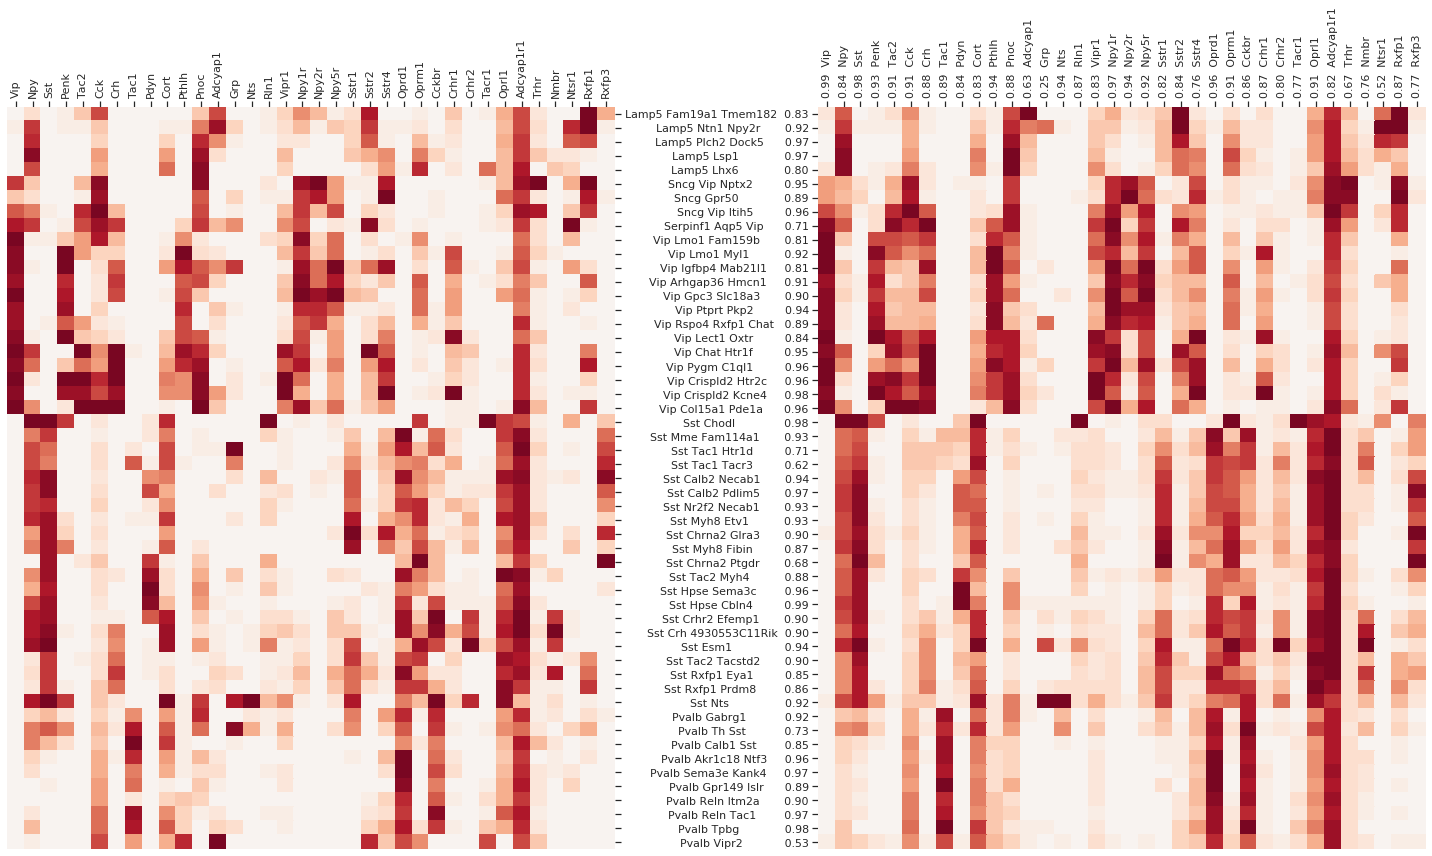

In [37]:
M_true = true_vals[:,gene_inds]/np.max(true_vals[:,gene_inds],axis=0)
M_pred = pred_vals[:,gene_inds]/np.max(pred_vals[:,gene_inds],axis=0)

Pearson_R_per_type_E_to_T = []
for i in range(M_true.shape[0]):
    C_ij = np.corrcoef(M_true[i,:],M_pred[i,:])
    Pearson_R_per_type_E_to_T.append(C_ij[0,1])
print(f'Pearson r per type mean: {np.mean(Pearson_R_per_type_E_to_T):0.2f} sd: {np.std(Pearson_R_per_type_E_to_T):0.2f}')

Pearson_R_per_feature = []
for i in range(M_true.shape[1]):
    C_ij = np.corrcoef(M_true[:,i],M_pred[:,i])
    Pearson_R_per_feature.append(C_ij[0,1])
print(f'Pearson r per feature mean: {np.mean(Pearson_R_per_feature):0.2f} sd: {np.std(Pearson_R_per_feature):0.2f}')

xlabels = genes_found

xname = [f.rstrip().lstrip() for f in xlabels]
xdata = Pearson_R_per_feature
xlabels2 = [f'{a:0.2f}  '+f'{b}' for (a,b) in zip(xdata,xname)] 

yname = [t for t in t_types]
ydata = [f'{x:.2f}' for x in Pearson_R_per_type_E_to_T]
ylabels = [f'{a:<23s}'+f'{b:>4s}' for (a,b) in zip(yname,ydata)]


plt.figure(figsize = (20,12))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=-1,vmax=1,center=0,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(['']*len(ylabels),rotation=0)


ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=-1,vmax=1,center=0,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)
ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels2,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()

#plt.savefig(figure_path+f'T_dat_pred_{subset}_genes.pdf')
#plt.savefig(figure_path+f'T_dat_pred_{subset}_genes.pdf')
plt.savefig(figure_path+'Fig_2a-b.pdf')
np.savetxt(figure_pth+'Fig_2a_source_xlabels.csv', np.array(xlabels), fmt='%s', delimiter=',', newline='\n', header='', footer='', comments='# ', encoding=None)
np.savetxt(figure_pth+'Fig_2a_source.csv', M_true, fmt='%f', delimiter=',', newline='\n', header='', footer='', comments='# ', encoding=None)
np.savetxt(figure_pth+'Fig_2b_source.csv', M_pred, fmt='%f', delimiter=',', newline='\n', header='', footer='', comments='# ', encoding=None)


### E reconstruction matrix

In [38]:
true_vals = []
pred_vals = []

for t in t_types:
    this_type = t_type_labels[val_ind]==t
    true_vals.append(np.nanmean(O['E_dat'][val_ind[this_type],:],axis=0))
    pred_vals.append(np.nanmean(XrE_from_XT[this_type,:],axis=0))

true_vals = np.concatenate(np.expand_dims(true_vals,0),axis=0)       
pred_vals = np.concatenate(np.expand_dims(pred_vals,0),axis=0)    

In [39]:
#Threshold chosen to match number of genes in the previous plot
keep_feature_ind = R2_E_to_E>0.42
M_true = true_vals[:,keep_feature_ind]/np.max(np.abs(true_vals[:,keep_feature_ind]),axis=0)
M_pred = pred_vals[:,keep_feature_ind]/np.max(np.abs(pred_vals[:,keep_feature_ind]),axis=0)

Pearson r per type mean: 0.98 sd: 0.02
Pearson r per feature mean: 0.95 sd: 0.04


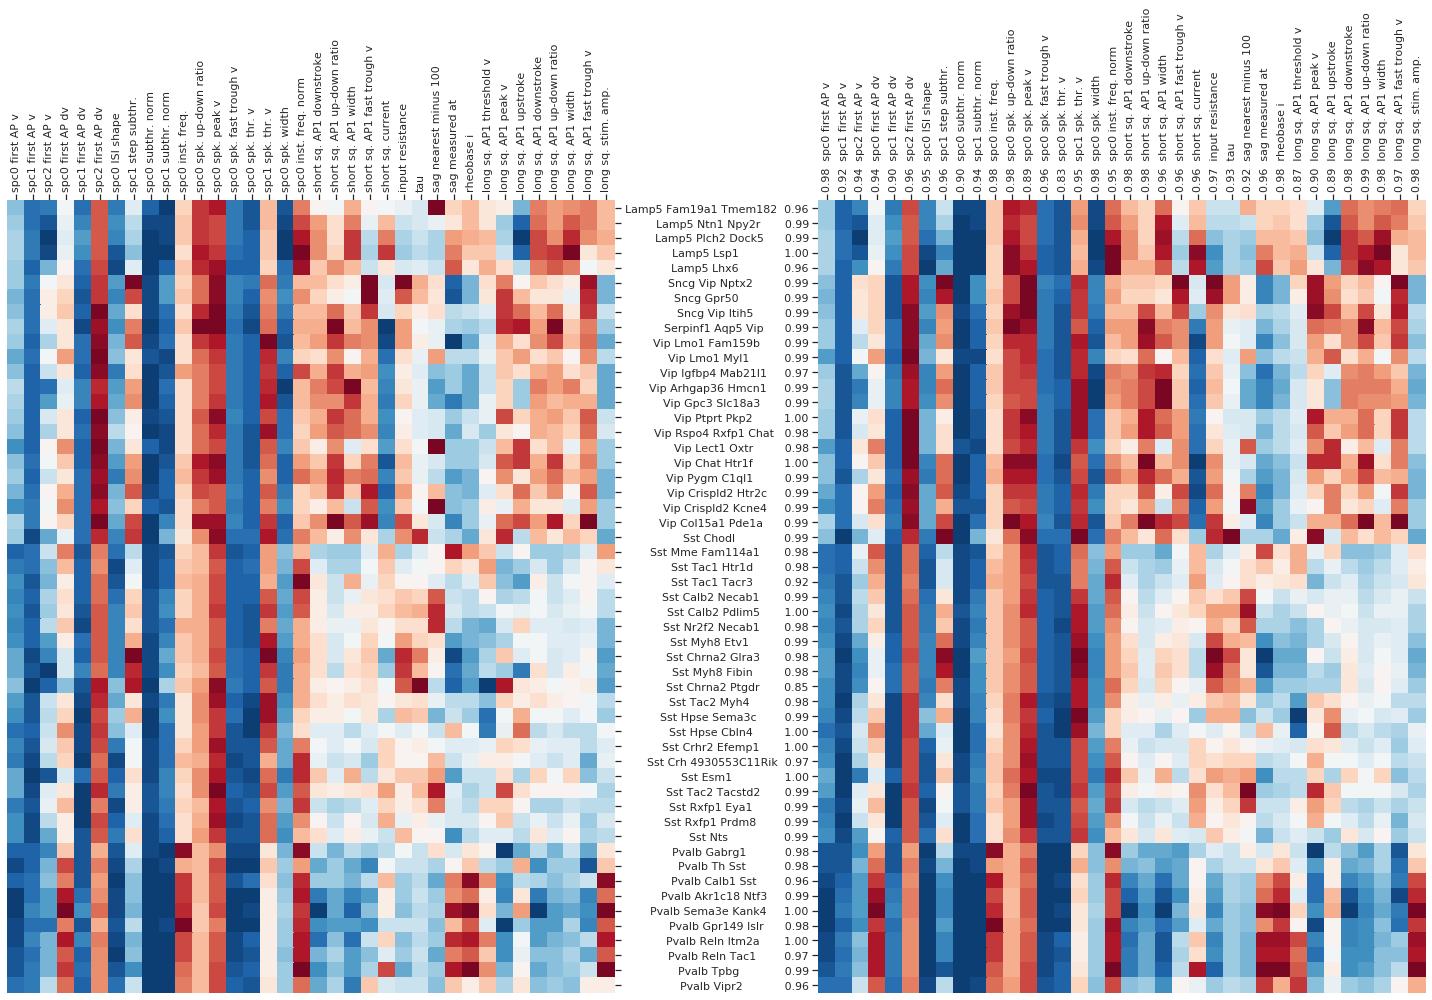

In [40]:
Pearson_R_per_type_T_to_E = []
for i in range(M_true.shape[0]):
    C_ij = np.corrcoef(M_true[i,:],M_pred[i,:])
    Pearson_R_per_type_T_to_E.append(C_ij[0,1])
print(f'Pearson r per type mean: {np.mean(Pearson_R_per_type_T_to_E):0.2f} sd: {np.std(Pearson_R_per_type_T_to_E):0.2f}')

Pearson_R_per_feature = []
for i in range(M_true.shape[1]):
    C_ij = np.corrcoef(M_true[:,i],M_pred[:,i])
    Pearson_R_per_feature.append(C_ij[0,1])
print(f'Pearson r per feature mean: {np.mean(Pearson_R_per_feature):0.2f} sd: {np.std(Pearson_R_per_feature):0.2f}')

xlabels = O['E_names'][keep_feature_ind]

xname = [f.rstrip().lstrip() for f in O['E_names'][keep_feature_ind]]
xdata = Pearson_R_per_feature
xlabels2 = [f'{a:0.2f}  '+f'{b}' for (a,b) in zip(xdata,xname)] 

yname = [t.rstrip().lstrip() for t in t_types]
ydata = [f'{x:.2f}' for x in Pearson_R_per_type_T_to_E]
ylabels = [f'{a:<23s}'+f'{b:>4s}' for (a,b) in zip(yname,ydata)]

plt.figure(figsize = (20,14))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=-1,vmax=1,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40))
cbar_kws={"aspect":30,"shrink":.5,"use_gridspec":False,"location":"right"}
ax = plt.gca()
ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(['']*len(ylabels),rotation=0)

ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=-1,vmax=1,cbar=False,cbar_kws=cbar_kws,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)

ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels2,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()

#plt.savefig(figure_path+'E_dat_pred.png',dpi=300)
plt.savefig(figure_path+'Fig_2c-d.pdf')
np.savetxt(figure_pth+'Fig_2c_source_xlabels.csv', np.array(xlabels), fmt='%s', delimiter=',', newline='\n', header='', footer='', comments='# ', encoding=None)
np.savetxt(figure_pth+'Fig_2c_source.csv', M_true, fmt='%f', delimiter=',', newline='\n', header='', footer='', comments='# ', encoding=None)
np.savetxt(figure_pth+'Fig_2d_source.csv', M_pred, fmt='%f', delimiter=',', newline='\n', header='', footer='', comments='# ', encoding=None)

### Summary for each t-type

In [15]:
#E features displayed before and after. 
ind_new = R2_E_to_E>0.42
ind_old = R2_T_to_E>0.252
print(f'{np.sum(np.logical_and(ind_new,ind_old))} selected features are the same')

28 selected features are the same
